In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import scipy.spatial as ss 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# 12-1 パターン認識の基本的なアプローチ
## 12-1-1 パターン認識の流れ
画像処理における**パターン認識**とは、観測された画像の特徴を用いて、あらかじめ定められたクラスにその画像を識別する処理である。
パターン認識では、パターンを同類の画像が共通に持つ特徴の組とする。
**クラス**とは、同じ画像が属する集合のことで、学習のためにはクラスをあらかじめ定める必要がある。
パターン認識には、距離計算を用いるアプローチと機械学習を用いるアプローチの2つがある。

## 12-1-2 画像からの特徴抽出
**特徴抽出**とは、入力画像からパターン認識に役立つ特徴を取り出す処理である。
取り出された$K$個の特徴量をそれぞれ$x_i$とすると、**特徴ベクトル**は$\boldsymbol{x}=(x_1,x_2,\cdots,x_K)^T$となる。
リンゴ、みかん、バナナの画像の赤みの度合いと円形度を計測し、それらを特徴とした特徴ベクトルをつくり、プロットすると図のように同じ種類のものが集まってクラスとなる。
この特徴ベクトルで構成される空間を**特徴空間**と呼ぶ。

## 12-1-3 プロトタイプ法による識別
---

In [2]:
def read_img(path, s):
    img_bgr = cv2.imread(path + '/' + s)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

def read_fruits_img(name, path='C:/Users/akihiro.tanaka.CORP/Downloads/pictures/'):
    path = path + name
 
    list1 = os.listdir(path)
    tmp = np.array([read_img(path, s) for s in list1])
    tmp_gray = np.array([cv2.cvtColor(s, cv2.COLOR_RGB2GRAY) for s in tmp])
    return tmp, tmp_gray

In [3]:
Apple_imgs, Apple_grays = read_fruits_img('Apple')
Orange_imgs, Orange_grays = read_fruits_img('Orange')
Avocado_imgs, Avocado_grays = read_fruits_img('Avocado')
Banana_imgs, Banana_grays = read_fruits_img('Banana')

FileNotFoundError: [WinError 3] 指定されたパスが見つかりません。: 'C:/Users/akihiro.tanaka.CORP/Downloads/pictures/Apple'

In [4]:
def calc_cnt(rgb, gray):
    img_g = gray.copy()
    img_c = rgb.copy()

    kernel = np.ones((3, 3), np.uint8)
    ret, thresh = cv2.threshold(img_g,250,255,cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, kernel, iterations = 6)
    thresh = cv2.erode(thresh, kernel, iterations = 2)
    thresh = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnt = contours[0]
    return cnt

In [5]:
def calc_roundness(rgb, gray):
    cnt = calc_cnt(rgb, gray)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    roundness = 4*np.pi*area / perimeter**2
    return roundness

In [6]:
def mean_col(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((3, 3), np.uint8)
    ret, thresh = cv2.threshold(gray,250,255,cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, kernel, iterations = 6)
    thresh = cv2.erode(thresh, kernel, iterations = 2)
    mask = cv2.bitwise_not(thresh)
    r = np.sum(rgb[:,:,0]*mask)/np.sum(mask==255)
    g = np.sum(rgb[:,:,1]*mask)/np.sum(mask==255)
    b = np.sum(rgb[:,:,2]*mask)/np.sum(mask==255)
    
    return np.array([r, g, b])

apple_rgb_mean = np.array([mean_col(s) for s in Apple_imgs])
apple_roundness = np.array([calc_roundness(s, t) for (s, t) in zip(Apple_imgs, Apple_grays)])

banana_rgb_mean = np.array([mean_col(s) for s in Banana_imgs])
banana_roundness = np.array([calc_roundness(s, t) for (s, t) in zip(Banana_imgs, Banana_grays)])

orange_rgb_mean = np.array([mean_col(s) for s in Orange_imgs])
orange_roundness = np.array([calc_roundness(s, t) for (s, t) in zip(Orange_imgs, Orange_grays)])

avocado_rgb_mean = np.array([mean_col(s) for s in Avocado_imgs])
avocado_roundness = np.array([calc_roundness(s, t) for (s, t) in zip(Avocado_imgs, Avocado_grays)])

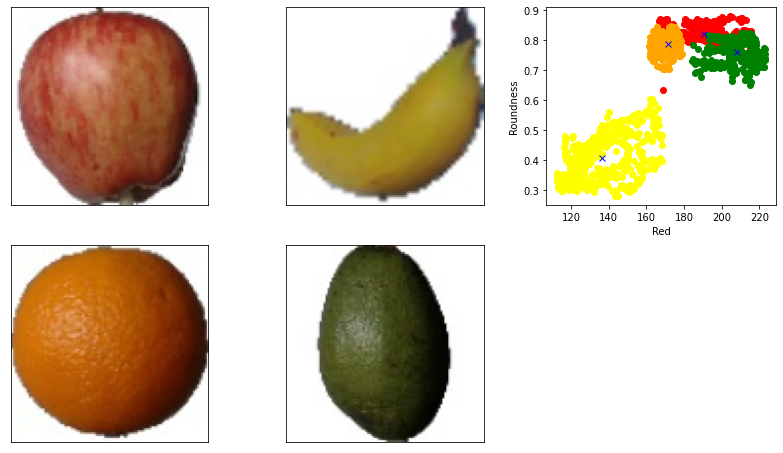

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(14, 8))

ax[0][0].imshow(Apple_imgs[0]);
ax[0][0].set_xticks([]);
ax[0][0].set_yticks([]);

ax[0][1].imshow(Banana_imgs[0]);
ax[0][1].set_xticks([]);
ax[0][1].set_yticks([]);

ax[1][0].imshow(Orange_imgs[0]);
ax[1][0].set_xticks([]);
ax[1][0].set_yticks([]);

ax[1][1].imshow(Avocado_imgs[0]);
ax[1][1].set_xticks([]);
ax[1][1].set_yticks([]);

ax[0][2].plot(apple_rgb_mean[:,1], apple_roundness, 'o', color='red')
ax[0][2].plot(banana_rgb_mean[:,1], banana_roundness, 'o', color='yellow')
ax[0][2].plot(orange_rgb_mean[:,1], orange_roundness, 'o', color='orange')
ax[0][2].plot(avocado_rgb_mean[:,1], avocado_roundness, 'o', color='green')
ax[0][2].plot(apple_rgb_mean[:,1].mean(), apple_roundness.mean(), 'x', color='blue');
ax[0][2].plot(banana_rgb_mean[:,1].mean(), banana_roundness.mean(), 'x', color='blue');
ax[0][2].plot(orange_rgb_mean[:,1].mean(), orange_roundness.mean(), 'x', color='blue');
ax[0][2].plot(avocado_rgb_mean[:,1].mean(), avocado_roundness.mean(), 'x', color='blue');

ax[0][2].set_xlabel("Red");
ax[0][2].set_ylabel("Roundness");

ax[1][2].axis('off');

## 12-1-4 クラスの分布を考慮した識別
平均値までのユークリッド距離が同じでも、広く分布しているクラスに識別したほうが誤りが少なくなることが直感的にわかる。
たとえば、学習用の入力画像群の分布に基づいた**マハラノビス距離**により識別を行うことがある。
まず、入力画像群の分布から、平均値と分散・共分散行列を求める。
ここで、クラス$c$に属し、$K$次元の$N^{(c)}$個の学習用入力画像群を$\boldsymbol{x}_n^{(c)}=(x_{n1},x_{n2},\cdots,x_{nK})^T,\ n=1,\cdots,N^{(c)}$とすると、クラスの平均ベクトル$\boldsymbol{M}^{(c)}$と**分散共分散行列**$\boldsymbol{S}^{(c)}$は次のようになる。
$$
\boldsymbol{M}^{(c)}=(M_1^{(c)},M_2^{(c)},\cdots,M_K^{(c)})^T
$$
ただし、
$$
M_i^{(c)}=\frac{1}{N^{(c)}}\sum_{n=1}^{N^{(c)}}x_{ni}
$$
$$
\boldsymbol{S}^{(c)}=
\left(
\begin{array}{ccc}
S_{11}^{(c)} & S_{12}^{(c)} & \cdots & S_{1K}^{(c)} \\
S_{21}^{(c)} & S_{22}^{(c)} & \cdots & S_{2K}^{(c)} \\
\vdots & \vdots & & \vdots \\
S_{K1}^{(c)} & S_{K2}^{(c)} & \cdots & S_{KK}^{(c)}
\end{array}
\right)
$$
ただし、
$$
S_{ij}^{(c)}=\frac{1}{N^{(c)}}\sum_{n=1}^{N^{(c)}}(x_{ni}-M_i^{(c)})(x_{nj}-M_j^{(c)})
$$
各クラスの平均ベクトル$\boldsymbol{M}^{(c)}$をプロトタイプとしたとき、テスト画像$\boldsymbol{x}$から各プロトタイプへのユークリッド距離の2乗は、
$$
d_e^{(c)}(\boldsymbol{x})=(\boldsymbol{x}-\boldsymbol{M}^{(c)})^T(\boldsymbol{x}-\boldsymbol{M}^{(c)})
$$
マハラノビス距離は、
$$
d_m^{(c)}(\boldsymbol{x})=(\boldsymbol{x}-\boldsymbol{M}^{(c)})^T(\boldsymbol{S}^{(c)})^{-1}(\boldsymbol{x}-\boldsymbol{M}^{(c)})
$$
となる。
マハラノビス距離は、平均値までの距離が同じでも広がりの大きい分布に対して短くなる距離である。

In [8]:
def make_S(feat1, feat2):
    xsize = feat1.shape[0]
    if len(feat1.shape)==1:
        ysize = 1
        print(1)
    else:
        print(1)
        ysize = feat1.shape[1]
    
    feat = np.concatenate([feat1.reshape(xsize, ysize)/255,
                                 feat2.reshape(feat2.shape[0], 1)],
                                axis=1)
    feat_M = feat.mean(axis=0)
    feat_c = feat - feat_M
    S = np.dot(feat_c.T, feat_c)
    return feat_M, S

def make_dist(x, y, feat_M, S):
    p = np.concatenate([xx.flatten().reshape(len(xx.flatten()),1), yy.flatten().reshape(len(xx.flatten()),1)], axis=1)
    d_euc = ((p - feat_M)*(p - feat_M)).sum(axis=1)
    d_mh = ((p - feat_M) * np.dot(np.linalg.inv(S), (p - feat_M).T).T).sum(axis=1)
    return d_euc, d_mh

In [9]:
M_apple, S_apple = make_S(apple_rgb_mean[:,1], apple_roundness)
M_banana, S_banana = make_S(banana_rgb_mean[:,1], banana_roundness)

x = np.arange(100,240)/255
y = np.arange(0.2,1,0.01)

xx, yy = np.meshgrid(x, y)

ap_euc, ap_mh = make_dist(xx, yy, M_apple, S_apple)
bn_euc, bn_mh = make_dist(xx, yy, M_banana, S_banana)

1
1


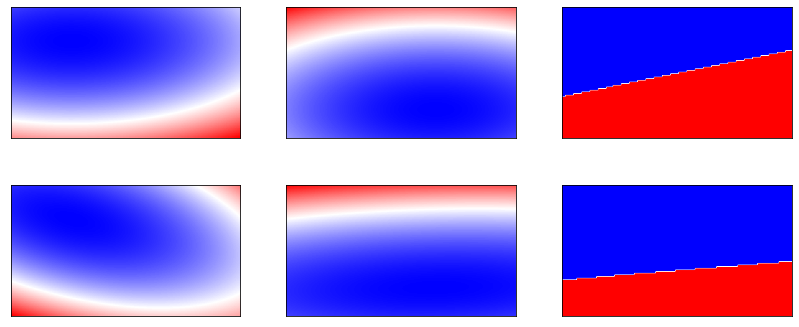

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

ax[0][0].imshow(bn_euc.reshape(len(y), len(x)), 'bwr')
ax[0][0].set_xticks([]);
ax[0][0].set_yticks([]);
ax[0][1].imshow(ap_euc.reshape(len(y), len(x)), 'bwr')
ax[0][1].set_xticks([]);
ax[0][1].set_yticks([]);

ax[1][0].imshow(bn_mh.reshape(len(y), len(x)), 'bwr')
ax[1][0].set_xticks([]);
ax[1][0].set_yticks([]);
ax[1][1].imshow(ap_mh.reshape(len(y), len(x)), 'bwr')
ax[1][1].set_xticks([]);
ax[1][1].set_yticks([]);

ax[0][2].imshow(bn_euc.reshape(len(y), len(x))>=ap_euc.reshape(len(y), len(x)), 'bwr')
ax[0][2].set_xticks([]);
ax[0][2].set_yticks([]);

ax[1][2].imshow(bn_mh.reshape(len(y), len(x))>=ap_mh.reshape(len(y), len(x)), 'bwr')
ax[1][2].set_xticks([]);
ax[1][2].set_yticks([]);

## 12-1-5 NN法とkNN法
**NN法**とは、ニアレストネイバーの略で最近傍の意味であり、テストデータに対して最も近傍の登録データを検索し、そのデータが属するクラスにテストデータを識別する。
テストデータの近傍の$k$個の登録データを検索し、帰属するサンプル数が最も多いクラスへテストデータを識別する方法が**kNN法**である。

In [11]:
app_feat = np.concatenate([apple_rgb_mean/255, apple_roundness.reshape(len(apple_roundness), 1)], axis=1)
bn_feat = np.concatenate([banana_rgb_mean/255, banana_roundness.reshape(len(banana_roundness), 1)], axis=1)

app_y = np.repeat(1, len(app_feat))
bn_y = np.repeat(2, len(bn_feat))

X = np.concatenate([app_feat, bn_feat])
y = np.concatenate([app_y, bn_y])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

nn = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
nn.fit(X_train, y_train)

nn.score(X_test, y_test)

1.0

In [12]:
app_feat = np.concatenate([apple_rgb_mean/255, apple_roundness.reshape(len(apple_roundness), 1)], axis=1)
bn_feat = np.concatenate([banana_rgb_mean/255, banana_roundness.reshape(len(banana_roundness), 1)], axis=1)

app_y = np.repeat(1, len(app_feat))
bn_y = np.repeat(2, len(bn_feat))

X = np.concatenate([app_feat, bn_feat])
y = np.concatenate([app_y, bn_y])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

nn = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
nn.fit(X_train, y_train)

nn.score(X_test, y_test)

1.0

## 12-1-6 kd-tree法
NN法は、最近傍探索を行う際にテストデータとすべての登録データの距離を計算するため、計算時間を要するという問題がある。
そこで、木構造を用いて高速な最近傍探索を実現する**kd-tree法**が利用されている。
多次元の特徴空間にある$N$個のデータの集合$\boldsymbol{P}=\{p_1,p_2,\cdots,p_N\}$を2分木により分割し、末端ノードにデータを格納する。
作成した2分木にテストデータを入力してトラバーサルすることにより最近傍探索を実現する。
kd-tree法による木の構築方法は次のようになる。

1. 分割する特徴次元を選択する
2. 選択した特徴次元において、中央値となる登録データを選択する。そのデータを通過し、座標軸に直交する超平面を用いて分割する。
3. 超平面により、分割したデータを左右の子ノードに保存する。
4. 子ノードにおいても1～3の処理を繰り返す。

In [13]:
app_feat = np.concatenate([apple_rgb_mean[:,1].reshape(len(apple_roundness), 1)/255, apple_roundness.reshape(len(apple_roundness), 1)], axis=1)
bn_feat = np.concatenate([banana_rgb_mean[:,1].reshape(len(banana_rgb_mean), 1)/255, banana_roundness.reshape(len(banana_roundness), 1)], axis=1)

app_y = np.repeat(1, len(app_feat))
bn_y = np.repeat(2, len(bn_feat))

X = np.concatenate([app_feat, bn_feat])
y = np.concatenate([app_y, bn_y])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

nn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
nn.fit(X_train, y_train)

nn.score(X_test, y_test)

1.0

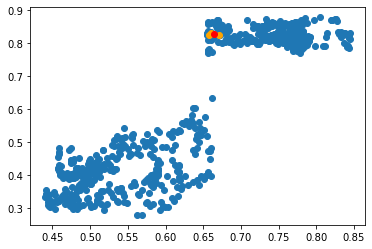

In [14]:
tree = KDTree(X_train, leaf_size=2)
dist, ind = tree.query(X_test[:1], k=3)

plt.plot(X_train[:,0], X_train[:,1], 'o')
plt.plot(X_train[ind,0], X_train[ind,1], 'o', color='orange')
plt.plot(X_test[0,0], X_test[0,1], 'o', color='red')

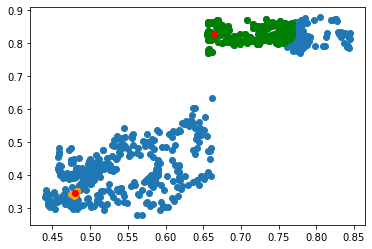

In [15]:
tree = ss.KDTree(X_train, leafsize=100)
r = 0.1

# 最近傍
d, i = tree.query(X_test[240], k=5)

# 領域（円）内
res = tree.query_ball_point(X_test[1,:], r)

plt.plot(X_train[:,0], X_train[:,1], 'o')
plt.plot(X_train[res,0], X_train[res,1], 'o', color='green')
plt.plot(X_train[i,0], X_train[i,1], 'o', color='orange')
plt.plot(X_test[0,0], X_test[0,1], 'o', color='red')
plt.plot(X_test[240,0], X_test[240,1], 'o', color='red')

## 12-1-8 線形判別分析
**線形判別分析**は、クラス間をよく識別する特徴を選択する手法である。
クラス間を離し、クラス内の入力画像を集める評価基準で規定を求める。
クラス$c$のパターン数を$N^{(c)}$、平均値を$\boldsymbol{M}^{(c)}$とし、全サンプル数を$N$、その平均ベクトルを$\boldsymbol{M}$としたとき、全サンプルの分散共分散行列$\boldsymbol{S}$は以下のようになる。
$$
\boldsymbol{S}=\frac{1}{N}\sum_{n=1}^{N}(\boldsymbol{x}_{n}-\boldsymbol{M})(\boldsymbol{x}_{n}-\boldsymbol{M})^T
$$
クラス$c$の分散共分散行列$\boldsymbol{S}^{(c)}$は、以下のようになる。
$$
\boldsymbol{S}^{(c)}=\frac{1}{N}\sum_{n=1}^{N^{(c)}}(\boldsymbol{x}_{n}-\boldsymbol{M}^{(c)})(\boldsymbol{x}_{n}-\boldsymbol{M}^{(c)})^T
$$
クラス内分散共分散行列$\boldsymbol{S}_w$とそのクラス間分散共分散行列$\boldsymbol{S}_b$は、次のようになる。
$$
\boldsymbol{S}_w=\frac{1}{N}\sum_{c}N^{(c)}\boldsymbol{S}^{(c)}\\
\boldsymbol{S}_b=\frac{1}{N}\sum_{c}N^{(c)}(\boldsymbol{M}^{(c)}-\boldsymbol{M})(\boldsymbol{M}^{(c)}-\boldsymbol{M})^T\\
\boldsymbol{S}=\boldsymbol{S}_w+\boldsymbol{S}_b
$$
クラス間の分離度を大きくするような$d$個の基底を求める問題は、以下の$\boldsymbol{S}_b\boldsymbol{S}_w^{-1}$の固有ベクトルを求める問題と同じになる。
$$
\boldsymbol{S}_b\boldsymbol{S}_w^{-1}\boldsymbol{u}_j=\lambda_j\boldsymbol{u}_j
$$


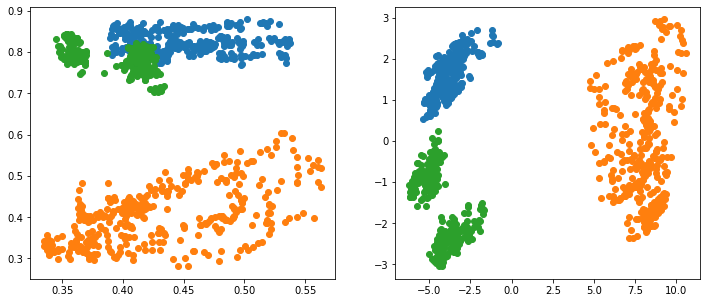

In [17]:
app_feat = np.concatenate([apple_rgb_mean/255, apple_roundness.reshape(len(apple_roundness), 1)], axis=1)
bn_feat = np.concatenate([banana_rgb_mean/255, banana_roundness.reshape(len(banana_roundness), 1)], axis=1)
or_feat = np.concatenate([orange_rgb_mean/255, orange_roundness.reshape(len(orange_roundness), 1)], axis=1)

app_y = np.repeat(1, len(app_feat))
bn_y = np.repeat(2, len(bn_feat))
or_y = np.repeat(3, len(or_feat))

X = np.concatenate([app_feat, bn_feat, or_feat])
y = np.concatenate([app_y, bn_y, or_y])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X_train, y_train).transform(X_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(3):
    ax[0].plot(X_train[y_train==i+1,0], X_train[y_train==i+1,3], 'o')
    ax[1].plot(X_r2[y_train==i+1,0], X_r2[y_train==i+1,1], 'o')

## 12-1-9 部分空間法
特徴空間の変換そのものを利用して識別する部分空間法を説明する。
### SELFIC法
学習用の入力画像数に比べて特徴の数が多いと、特徴空間が広すぎ、真のクラスのまとまりが正確に推定できず、識別能力が劣化することがある。
そのときには、主成分分析を用いて少数の特徴量にし、識別に不要な特徴を取り除いて、テスト画像への識別能力を上げることができる場合がある。
このように低次元にした特徴空間で、プロトタイプとの距離やマハラノビス距離などのクラスの近さに基づく識別方法を**SELFIC法**と呼ぶ。

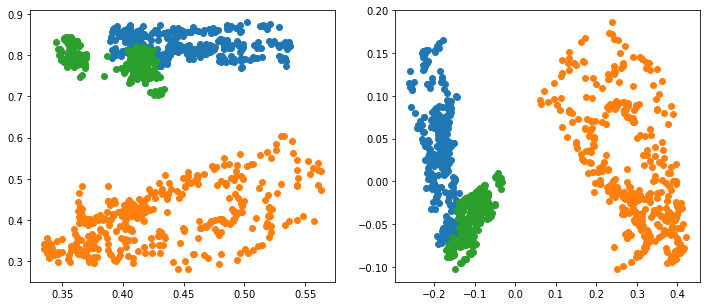

In [18]:
pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(3):
    ax[0].plot(X_train[y_train==i+1,0], X_train[y_train==i+1,3], 'o')
    ax[1].plot(X_r[y_train==i+1,0], X_r[y_train==i+1,1], 'o')

# 12-2 機械学習の概要
## 12-2-1 教師なし学習
**教師なし学習**は、学習データのみからデータの性質を理解することであり、クラスタリングや次元圧縮に用いられる。
クラスタリングは、学習データに内在するクラスタを見つけ出す問題である。次元圧縮は、学習データの多次元情報を、その意味を保ちつつ、より少ない次元の情報に削減する問題であり、データの圧縮や可視化に用いられる。

## 12-2-2 教師あり学習
**教師あり学習**は、学習データとその正解情報からモデルを学習して未知の情報を予測することであり、クラス分類と回帰問題の2つの問題設定を行う。クラス分類は、学習データを入力し、その学習データが属するクラスラベルを出力するように識別モデルを構築して、未知データが属するクラスを求める問題である。回帰問題は、学習データを入力し、その学習データの出力である実数値を出力するように回帰モデルを構築し、未知データの情報を予測する問題である。

# 12-3 教師なし学習とクラスタリング
教師なし学習は、学習データのみからデータの性質を理解することである。
## 12-3-1 k-means法によるクラスタリング
ある特徴空間のなかでクラスごとに識別対象の入力画像が集まって存在することを仮定して、クラスごとに属する画像を同時に求める。
この処理を**クラスタリング**と呼ぶ。
**k-means法**は、入力画像を分割するクラス数をあらかじめ$k$個と設定して分割し、これを初期状態として分割を繰り返し修正することで、よりよい分割を探し出す方法である。

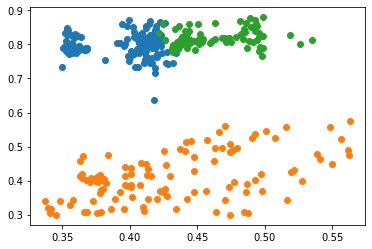

In [19]:
km = KMeans(n_clusters=3)
km.fit(X_train, y_train)
pred_test = km.predict(X_test)

for i in range(3):
    plt.plot(X_test[pred_test==i,0], X_test[pred_test==i,3], 'o')

## 12-3-2 主成分分析による次元圧縮
**主成分分析**は、多次元の特徴空間に分散する多数の学習用入力画像から、分布をよく表現できる低次元の特徴空間を求める手法である。
この低次元の特徴空間を**部分空間**と呼ぶ。
ここで、$N$個の学習用の入力画像群の特徴量を$K$個とすると、入力画像は、特徴ベクトル$\boldsymbol{x}_n=(x_{n1},x_{n2},\cdots,x_{nK})^T,n=1,\cdots,N$となる。その平均ベクトル$\boldsymbol{M}$と分散共分散行列$\boldsymbol{S}$を以下により求める。
$$
\boldsymbol{M}=\frac{1}{N}\sum_{n=1}^N\boldsymbol{x}_n\\
\boldsymbol{S}=\frac{1}{N}\sum_{n=1}^N(\boldsymbol{x}_n-\boldsymbol{M})(\boldsymbol{x}_n-\boldsymbol{M})^T
$$

主成分分析では、入力画像の特徴空間での分布において、平均値となる点を通り、広がりの最も大きい方向の直線である第1主成分を求める。
次に、その第1主成分に直交しかつ平均を通る2番目に広がりの大きい方向の第2主成分の直線を求める。
これは、分散共分散行列を用いて
$$
\boldsymbol{S}\boldsymbol{u}_j=\lambda_j\boldsymbol{u}_j
$$
を満たす**固有値**$\lambda_j$と**固有ベクトル**$\boldsymbol{u}_j$を求める。
固有値$\lambda_j$の大きい方からそれに対応する固有ベクトル$\boldsymbol{u}_j$を$d$個選ぶと$d$次元の主成分が求まる。
顔の画像で主成分分析を行ってみる。平均画像と5つの主成分を画像化したものは次のようになる。

In [16]:
endo, endo_gray = read_fruits_img('endo', path='C:/Users/tanak/image/face/')
ikuta, ikuta_gray = read_fruits_img('ikuta', path='C:/Users/tanak/image/face/')
saito, saito_gray = read_fruits_img('saito', path='C:/Users/tanak/image/face/')
yamashita, yamashita_gray = read_fruits_img('yamashita', path='C:/Users/tanak/image/face/')

In [30]:
y.shape

(802, 64, 64, 3)

In [31]:
X = np.concatenate([endo_gray, ikuta_gray, saito_gray, yamashita_gray])
X_flat = X.flatten().reshape(len(X),64**2)/255.

endo = np.repeat(1, len(endo_gray))
ikuta = np.repeat(2, len(ikuta_gray))
saito = np.repeat(3, len(saito_gray))
yamashita = np.repeat(4, len(yamashita_gray))
y = np.concatenate([endo, ikuta, saito, yamashita])

In [21]:
pca = PCA(n_components=50, whiten=True).fit(X_flat)
X_pca = pca.transform(X_flat)

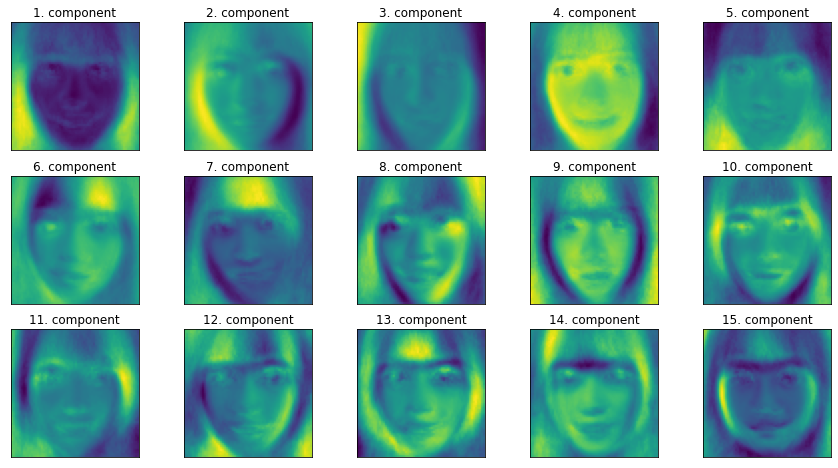

In [32]:
fix, axes = plt.subplots(3, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_[:15], axes.ravel())):
    ax.imshow(component.reshape(64,64), cmap='viridis')
    ax.set_title("{}. component".format((i+1)))

# 12-4 教師あり学習
## 12-4-1 アダブースト
複数の識別器を組み合わせて1つの強力な識別器を学習するアンサンブル学習の1つとして、**アダブースト**がある。
アダブーストは、2クラス分類問題に対して、逐次的に学習サンプルの重みを更新しながら識別器を選択することを繰り返し、最終的な識別関数を学習する。個々の識別器を**弱識別器**と呼び、それらを組み合わせた識別器を**強識別器**と呼ぶ。
まず、学習サンプルに対して均一の重みを与える。学習が始まり、1つの弱識別器が選択されると、正しく識別できるサンプルは重みが小さく、誤識別したサンプルの重みは大きくなる。次の弱識別器の学習では、学習サンプルの重みを考慮して、誤識別した学習サンプルを正しく識別する弱識別器が選択される。
この処理を繰りかえして複数の弱識別器が選択される。

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y)
ada = AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.002, n_estimators=300)
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

1.0
0.43283582089552236


## 12-4-2 サポートベクタマシン
汎化能力の高い統計的学習手法の1つに、**サポートベクターマシン(SVM)**がある。
SVMでは、2クラスの分布を分ける超平面を決める際に、マージン最大化という考え方を導入しているため、高い識別性能をもつ。
#### ハードマージンSVM
ハードマージンSVMの線形識別器の識別関数$f(\boldsymbol{x})$は、以下のように表すことができる。
$$
f(\boldsymbol{x})=sgn(\boldsymbol{w}^T\boldsymbol{x}+b)
$$

$\boldsymbol{x}\in R^d$は$d$次元の特徴量、$\boldsymbol{w}\in R^d$は重みベクトル、$b\in R^d$はバイアス項である。
識別関数$f(\boldsymbol{x})$は、特徴量と重みベクトルの内積にバイアス項を加えた値が0よりも大きい場合に1、小さい場合に-1を出力する。つまり、特徴空間を超平面により2つに分けることを表す。
学習ではマージン$d$を最大とするような超平面の重みベクトル$\boldsymbol{w}$とバイアス項$b$を求めることになる。
#### ソフトマージンSVM
ハードマージンSVMは、学習サンプルの線形分離が可能であることを仮定している。
しかし、すべての問題において線形分離ができるわけではない。
そのような場合、ある程度の誤差を許容して超平面を決定する手法として、ソフトマージンの概念を導入した**ソフトマージンSVM**を適用する。
ソフトマージンSVMでは、ハードマージンSVMの目的関数にスラック変数$\xi_i$をペナルティ港として付き加えて、最小化を行う。
#### カーネルトリック
特徴量を非線形写像により高次元空間に写像し、高次元空間において線形分離可能な超平面を決定することを考える。
こうして求められた超平面は非線形な境界線となるが、計算量が爆発的に増える。
この計算量の問題を防ぐテクニックとして**カーネルトリック**がある。
カーネル関数を計算するのみで非線形な識別器の学習が可能となる。

In [38]:
svc = LinearSVC(C=0.01)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

0.7371048252911814
0.6019900497512438


In [39]:
svm = SVC(kernel='rbf', C=0.9, gamma=0.01)
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.8435940099833611
0.6567164179104478


## 12-4-3 ランダムフォレスト
**ランダムフォレスト**とは、複数の決定木構造を持った多クラス識別器を構築するアンサンブル学習アルゴリズムである。
ランダムフォレストは、学習サンプルをランダムサンプリングにより作成したサブセットごとに決定木を構築し、複数の決定木の結果を統合して識別する。

In [40]:
rf = RandomForestClassifier(n_estimators=60, max_features=40, max_leaf_nodes=60)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9916805324459235
0.5970149253731343


# 12-5 機械学習による画像認識の応用例
## 12-5-1 物体検出
物体検出とは、あるカテゴリに属する物体が画像中のどこに存在するかを求める問題である。
顔検出や人検出などの物体検出法では、検出ウィンドウのラスタスキャンにより、検出対象の位置を検出する。
カメラと検出対象の物体の距離に応じて画像中の検出対象物体の大きさが変化するため、同一サイズのウィンドウでは異なる大きさの物体を検出することはできない。そこで、入力画像からイメージピラミッドを作成し、各解像度の画像に対して検出ウィンドウをラスタスキャンすることで、マルチスケールの物体検出を実現する。

### 顔検出と顔識別
顔画像の特徴を捉える特徴量として、明暗差に着目した**Haar-like特徴量**が用いられている。
Haar-like特徴量は、以下に示すように、2つの矩形領域の平均輝度の差を特徴量とする。
$$
H(r1,r2)=S(r1)-S(r2)
$$

ここで、$S(r)$は領域$r$の平均輝度を算出する関数である。

In [41]:
img1 = read_img('C:/Users/akihiro.tanaka.CORP/Downloads/pictures/', 'yonsentoshin.jpg')

face_cascade = cv2.CascadeClassifier('C:/Python38/Lib/site-packages/cv2/data/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('C:/Python38/Lib/site-packages/cv2/data/haarcascade_eye.xml')

# イメージファイルの読み込み

def detect_face(img):
    img = img.copy()

    # グレースケール変換
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 顔を検知
    faces = face_cascade.detectMultiScale(img)
    for (x,y,w,h) in faces:
        # 検知した顔を矩形で囲む
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        # 顔画像（グレースケール）
        roi_gray = gray[y:y+h, x:x+w]
        # 顔画像（カラースケール）
        roi_color = img[y:y+h, x:x+w]
        # 顔の中から目を検知
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            # 検知した目を矩形で囲む
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    return img

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(detect_face(nishino[7]))
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(detect_face(img1))
ax[1].set_xticks([]);
ax[1].set_yticks([]);

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y)
X_train = X_train.reshape(len(X_train), 64, 64)
X_test = X_test.reshape(len(X_test), 64, 64)

recognizer = cv2.face.LBPHFaceRecognizer_create() 
recognizer.train(X_train, np.array(y_train))

fig, ax = plt.subplots(3, 5, figsize=(16, 8))
for i in range(15):
    id, confidence = recognizer.predict(X_test[i])
    ax[i//5][i%5].imshow(X_test[i])
    ax[i//5][i%5].set_xticks([])
    ax[i//5][i%5].set_yticks([])
    ax[i//5][i%5].set_title('pred:{}, ans:{}, {}'.format(id, y_test[i], round(100-confidence, 1)))

NameError: name 'train_test_split' is not defined

#### 人検出
人検出では、情報をヒストグラム化した**HOG特徴量**が利用されている。
HOG特徴量を画像から求め、画像をセルと呼ばれる矩形に分割し、セルごとに勾配方向ヒストグラム$h(\theta')$を作成する。
最後に複数のセルで構成されるブロックを用いて、勾配ヒストグラムを正規化する。
そして学習サンプルからHOG特徴量を抽出したら、SVMによる識別器の学習を行う。

In [30]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/egi.jpg")
h, w = img_bgr.shape[:2]
img_bgr_resize = img_bgr
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)

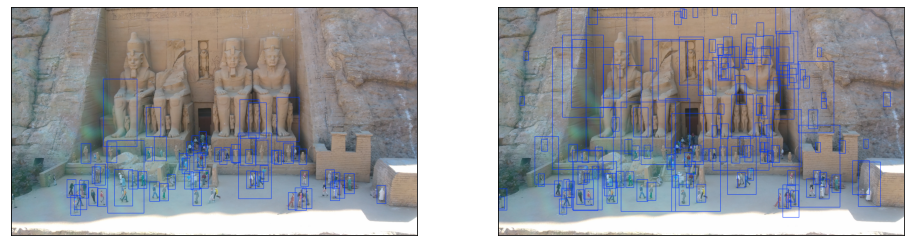

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

for i in range(2):
    img = img_rgb.copy()

    if i == 0:
        hog = cv2.HOGDescriptor()
        hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    else:
        hog = cv2.HOGDescriptor((48,96), (16,16), (8,8), (8,8), 9)
        hog.setSVMDetector(cv2.HOGDescriptor_getDaimlerPeopleDetector())

    hogParams = {'winStride': (8, 8), 'padding': (4, 4), 'scale': 1.05}

    human, r = hog.detectMultiScale(img, **hogParams)

    for (x, y, w, h) in human:
        cv2.rectangle(img, (x, y),(x+w, y+h),(0,50,255), 4)

    ax[i].imshow(img);
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);

## 12-5-2 類似画像検索
画像検索とは、入力画像を画像データベースと照合し、画像内の物体情報を探し出すことである。
このような画像検索には**BoVW(Bag of Visual Words)**という画像特徴表現と最近傍探索により実現できる。
BoVW表現とは、SIFTなどの特徴ベクトルをk-means法によりクラスタリングする。そして、各クラス中心をvisual wordsとして辞書を作成する。入力画像から抽出した局所特徴からvisual wordsごとの出現頻度をヒストグラムで表現するアプローチがBoVWである。

In [54]:
X = np.concatenate([endo_gray, ikuta_gray, saito_gray, yamashita_gray])
X_flat = X.flatten().reshape(len(X),64**2)

shira = np.repeat(1, len(endo_gray))
nishi = np.repeat(2, len(ikuta_gray))
aki = np.repeat(3, len(saito_gray))
iku = np.repeat(4, len(yamashita_gray))
y = np.concatenate([shira, nishi, aki, iku])

X_test = X_flat.reshape(len(X_flat), 64,64)

In [57]:
k = 8
detector = cv2.KAZE_create()
bowTrainer = cv2.BOWKMeansTrainer(k)
for file in X:
    image = file.copy()
    if image is not None:
        _, descriptors = detector.detectAndCompute(image, None)
    if descriptors is not None:
        bowTrainer.add(descriptors.astype(np.float32))
centroids = bowTrainer.cluster()

In [58]:
matcher = cv2.BFMatcher()
extractor = cv2.BOWImgDescriptorExtractor(detector, matcher)
extractor.setVocabulary(centroids)
probs_train = []

for file in X:
    descriptor = None
    image = file.copy()
    if image is not None:
        keypoints = detector.detect(image, None)
        if keypoints is not None:
            descriptor = extractor.compute(image, keypoints)[0]
    probs_train.append(descriptor)

In [63]:
matcher = cv2.BFMatcher()
extractor = cv2.BOWImgDescriptorExtractor(detector, matcher)
extractor.setVocabulary(centroids)
probs_test = []

for file in X:
    descriptor = None
    image = file.copy()
    if image is not None:
        keypoints = detector.detect(image, None)
        if keypoints is not None:
            descriptor = extractor.compute(image, keypoints)[0]
    probs_test.append(descriptor)

In [64]:
prob = np.zeros([len(probs_test), len(probs_train)])

rank = []
for i, p1 in enumerate(probs_test):
    tmp = []
    for j, p2 in enumerate(probs_train):
        tmp.append([j,sum(map(lambda x: min(x[0], x[1]), zip(p1, p2)))])
    rank.append(sorted(tmp, key = lambda x: - x[1])[:5])
rank = np.array(rank)

In [1]:
fig, ax = plt.subplots(5, 6, figsize=(18, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i in range(55):
    ax[i//5][0].imshow(X[i//5])
    ax[i//5][i%5+1].imshow(X[int(rank[i//5,i%5,0])])
    ax[i//5][i%5+1].set_title('prob:{}'.format(round(rank[i//5,i%5,1]*100, 2)))

NameError: name 'plt' is not defined

## 12-5-3 人体姿勢推定
---


In [72]:
rank[5//5,0,0]

1.0